In [21]:
## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()


import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torch.optim as optim
import os
import random
import pickle
import torchvision
import shutil
from torchvision import transforms
from tqdm import tqdm

C:\Users\przek\AppData\Local\Temp\ipykernel_80020\2949133806.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [22]:
torch.cuda.set_device(0)
device = torch.device("cuda")

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_all_seeds(42)

# Read data

## Oversampling

In [23]:
def over_sample(path):
    classes = os.listdir(path)
    num_class = {}

    for i in range(len(classes)):
        num_of_class = len(os.listdir(f"{path}/{classes[i]}"))
        num_class[classes[i]] = num_of_class

    max_num_class = max(num_class.values())

    for key in num_class:
        copy_all = max_num_class // num_class[key] - 1
        copy_sample = max_num_class % num_class[key]

        images = os.listdir(f"{path}/{key}")
        to_copy_sample = random.sample(images, k=copy_sample)
        ind = 0
        for i in range(copy_all):
            for image in images:

                shutil.copytree(f"{path}/{key}/{image}", f"{path}/{key}/{image}_{i}")
            ind += 1
        for image in to_copy_sample:
            shutil.copytree(f"{path}/{key}/{image}", f"{path}/{key}/{image}_{ind}")


## Create val folder

In [24]:
def create_val_folder():
    sub_folders = os.listdir("./trafic_32")
    os.mkdir("./val_trafic_32")
    for sub_folder in sub_folders:
        os.mkdir(f"./val_trafic_32/{sub_folder}")

    for sub_folder in sub_folders:
        images_list = os.listdir(f"./trafic_32/{sub_folder}")
        to_move = random.sample(images_list, k=(len(images_list) // 5))
        for image in to_move:
            shutil.move(f"./trafic_32/{sub_folder}/{image}", f"./val_trafic_32/{sub_folder}/{image}")


In [25]:
def check_classes_amounts(path):
    classes = os.listdir(path)
    num_all = 0
    num_class = []
    for i in range(len(classes)):
        num_of_class = len(os.listdir(f"{path}/{classes[i]}"))
        num_class.append(num_of_class)
        num_all += num_of_class
    print(f"Number of all examples: {num_all}\nNumbers of every class: {num_class}")
    # return num_all, num_class

In [26]:
check_classes_amounts("./trafic_32")

Number of all examples: 77400
Numbers of every class: [1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800]


In [27]:
# create_val_folder()

In [28]:
check_classes_amounts("./val_trafic_32")

Number of all examples: 7841
Numbers of every class: [42, 444, 450, 282, 396, 372, 84, 288, 282, 294, 402, 264, 420, 432, 156, 126, 84, 222, 240, 42, 72, 66, 78, 102, 54, 300, 120, 48, 108, 54, 90, 156, 48, 137, 84, 240, 78, 42, 414, 60, 72, 48, 48]


In [29]:
check_classes_amounts("./trafic_32")

Number of all examples: 77400
Numbers of every class: [1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800]


In [30]:
# over_sample("./trafic_32")

In [31]:
check_classes_amounts("./trafic_32")

Number of all examples: 77400
Numbers of every class: [1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800, 1800]


## Data preparation

In [93]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.ImageFolder("trafic_32/", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


val_dataset = datasets.ImageFolder("val_trafic_32/", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

In [33]:
# does not work after transfation from image format to tensor
# from IPython.display import display
#
# image_num = 31367
# scale = 4
# display(train_dataset[image_num][0].resize(( int(train_dataset[image_num][0].width * scale), int(train_dataset[image_num][0].height * scale))))

# Net preparation

In [94]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear (hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x       = self.LeakyReLU(self.fc_1(x))
        x       = self.LeakyReLU(self.fc_2(x))
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)

        return mean, log_var

In [95]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h     = self.LeakyReLU(self.fc_1(x))
        h     = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        # x_hat = x_hat.view([-1, 1, 28, 28])
        x_hat = x_hat.view([-1, 3, 32, 32])
        return x_hat


In [96]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)


    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)        # sampling epsilon
        z = mean + var * epsilon
        return z


    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [97]:
def vae_loss_function(x, x_hat, mean, log_var):


    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    if reproduction_loss.item() < 99999:
        pass
    else:
        reproduction_loss.item = 99999
    # print(f"rep_loss -> {reproduction_loss}")
    KLD      = min(99999, -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()))
    # print(f"KLD -> {KLD}")

    return reproduction_loss + KLD

In [98]:
vae = VAE(latent_dim=256, hidden_dim=2048, x_dim=3072).to(device)
# vae.load_state_dict(torch.load("SSNE-lab-5/vae_40"))

In [99]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [100]:
num_epochs = 40
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in tqdm(iter(train_loader)):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    # if n % 10 == 0:
    for x, _ in iter(val_loader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()



100%|██████████| 604/604 [00:24<00:00, 24.27it/s]


Epoch 0 loss 12625.950251092974, test L1 = 0.09439921775652517


100%|██████████| 604/604 [00:24<00:00, 24.85it/s]


Epoch 1 loss 8779.996305554117, test L1 = 0.08862854864808821


100%|██████████| 604/604 [00:24<00:00, 24.47it/s]


Epoch 2 loss 8045.51022642022, test L1 = 0.085529972829165


100%|██████████| 604/604 [00:24<00:00, 24.41it/s]


Epoch 3 loss 7641.29616521368, test L1 = 0.08357648190952116


100%|██████████| 604/604 [00:24<00:00, 24.73it/s]


Epoch 4 loss 7434.402688133796, test L1 = 0.07962796031948059


100%|██████████| 604/604 [00:31<00:00, 19.11it/s]


Epoch 5 loss 7202.406020410803, test L1 = 0.07960398230821855


100%|██████████| 604/604 [00:25<00:00, 23.31it/s]


Epoch 6 loss 7051.2706104809085, test L1 = 0.07841435867932535


100%|██████████| 604/604 [00:25<00:00, 24.13it/s]


Epoch 7 loss 6920.911968711196, test L1 = 0.07963515703956928


100%|██████████| 604/604 [00:25<00:00, 23.47it/s]


Epoch 8 loss 6808.354479252897, test L1 = 0.07873523812140187


100%|██████████| 604/604 [00:25<00:00, 23.38it/s]


Epoch 9 loss 6717.679071489549, test L1 = 0.07901092624712375


100%|██████████| 604/604 [00:25<00:00, 23.97it/s]


Epoch 10 loss 6612.625353276335, test L1 = 0.07688845874321076


100%|██████████| 604/604 [00:24<00:00, 24.29it/s]


Epoch 11 loss 6529.971026490066, test L1 = 0.07624677821032462


100%|██████████| 604/604 [00:24<00:00, 24.46it/s]


Epoch 12 loss 6481.2480355572225, test L1 = 0.07506099469479054


100%|██████████| 604/604 [00:25<00:00, 23.85it/s]


Epoch 13 loss 6404.212581811362, test L1 = 0.0745482342618127


100%|██████████| 604/604 [00:24<00:00, 24.31it/s]


Epoch 14 loss 6335.560686730391, test L1 = 0.07525847371547453


100%|██████████| 604/604 [00:24<00:00, 24.66it/s]


Epoch 15 loss 6283.28571728839, test L1 = 0.0746050410934033


100%|██████████| 604/604 [00:30<00:00, 19.66it/s]


Epoch 16 loss 6239.86483097708, test L1 = 0.07477019144402396


100%|██████████| 604/604 [00:25<00:00, 23.94it/s]


Epoch 17 loss 6180.1927910608965, test L1 = 0.07460805353137755


100%|██████████| 604/604 [00:25<00:00, 23.72it/s]


Epoch 18 loss 6154.738182623655, test L1 = 0.072729944762203


100%|██████████| 604/604 [00:28<00:00, 21.43it/s]


Epoch 19 loss 6077.667928329367, test L1 = 0.07333248210770468


100%|██████████| 604/604 [00:27<00:00, 21.63it/s]


Epoch 20 loss 6046.191470114601, test L1 = 0.07328195437308281


100%|██████████| 604/604 [00:28<00:00, 20.91it/s]


Epoch 21 loss 6016.960711952866, test L1 = 0.07381158508360386


100%|██████████| 604/604 [00:26<00:00, 23.05it/s]


Epoch 22 loss 5970.2487170490995, test L1 = 0.07181773905552202


100%|██████████| 604/604 [00:24<00:00, 24.36it/s]


Epoch 23 loss 5937.289284813483, test L1 = 0.07318881814998965


100%|██████████| 604/604 [00:23<00:00, 25.67it/s]


Epoch 24 loss 5914.494096162303, test L1 = 0.07297297056403852


100%|██████████| 604/604 [00:23<00:00, 25.73it/s]


Epoch 25 loss 5880.851527738256, test L1 = 0.07223318505191034


100%|██████████| 604/604 [00:23<00:00, 25.29it/s]


Epoch 26 loss 5842.236116320882, test L1 = 0.07247106172144413


100%|██████████| 604/604 [00:30<00:00, 20.13it/s]


Epoch 27 loss 5801.707746695209, test L1 = 0.07153902695544305


100%|██████████| 604/604 [00:29<00:00, 20.26it/s]


Epoch 28 loss 5786.795733521316, test L1 = 0.0722644706406901


100%|██████████| 604/604 [00:27<00:00, 21.74it/s]


Epoch 29 loss 5766.905890256364, test L1 = 0.07216548751438817


100%|██████████| 604/604 [00:25<00:00, 23.34it/s]


Epoch 30 loss 5732.130190817726, test L1 = 0.0711713417643501


100%|██████████| 604/604 [00:23<00:00, 25.95it/s]


Epoch 31 loss 5705.748658843388, test L1 = 0.0709850954552812


100%|██████████| 604/604 [00:25<00:00, 23.93it/s]


Epoch 32 loss 5680.008219939983, test L1 = 0.07117725488158964


100%|██████████| 604/604 [00:27<00:00, 22.07it/s]


Epoch 33 loss 5671.50680845147, test L1 = 0.0714764287394862


100%|██████████| 604/604 [00:27<00:00, 21.87it/s]


Epoch 34 loss 5629.652447226821, test L1 = 0.07123959725422244


100%|██████████| 604/604 [00:30<00:00, 20.07it/s]


Epoch 35 loss 5613.351239134934, test L1 = 0.07080723213091973


100%|██████████| 604/604 [00:28<00:00, 21.35it/s]


Epoch 36 loss 5593.208171111858, test L1 = 0.07127951169686933


100%|██████████| 604/604 [00:27<00:00, 22.02it/s]


Epoch 37 loss 5573.1115116346755, test L1 = 0.07061247990256356


100%|██████████| 604/604 [00:28<00:00, 21.12it/s]


Epoch 38 loss 5557.887760793926, test L1 = 0.07124356432787833


100%|██████████| 604/604 [00:28<00:00, 21.08it/s]


Epoch 39 loss 5544.307432060999, test L1 = 0.0705521300194725


In [101]:
torch.save(vae.state_dict(), "vae_40_P_40epochs")

In [102]:
vae.load_state_dict(torch.load("vae_40_os_256_2048_bs128_40e"))
vae.state_dict()

OrderedDict([('encoder.fc_1.weight',
              tensor([[ 0.0364,  0.0218, -0.0214,  ...,  0.0315,  0.0399,  0.0332],
                      [ 0.0819,  0.0565,  0.0642,  ...,  0.0552,  0.0116,  0.0416],
                      [-0.0251, -0.0149, -0.0344,  ..., -0.0221,  0.0020,  0.0541],
                      ...,
                      [-0.0431, -0.0189, -0.0111,  ..., -0.0075, -0.0035, -0.0820],
                      [ 0.0093, -0.0106,  0.0261,  ..., -0.0242, -0.0075, -0.0012],
                      [ 0.0111,  0.0068,  0.0161,  ...,  0.0198,  0.0222, -0.0173]],
                     device='cuda:0')),
             ('encoder.fc_1.bias',
              tensor([-0.1328,  0.1793, -0.0138,  ...,  0.6099, -0.1964, -0.6860],
                     device='cuda:0')),
             ('encoder.fc_2.weight',
              tensor([[-2.3702e-02,  2.4609e-02, -2.5525e-02,  ..., -1.9559e-03,
                        1.6000e-02,  2.0299e-02],
                      [ 2.4900e-02, -2.0706e-03,  1.7610e-02,  ..

In [103]:
def get_train_images(start, num):
    return torch.stack([val_dataset[i][0] for i in range(start,start+num)], dim=0)

In [104]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

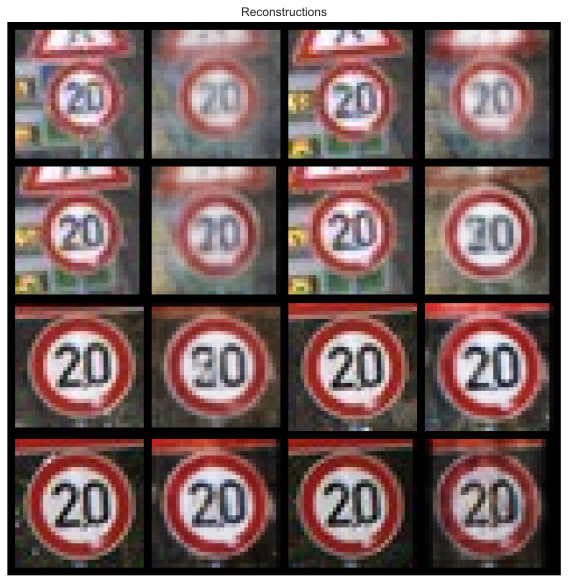

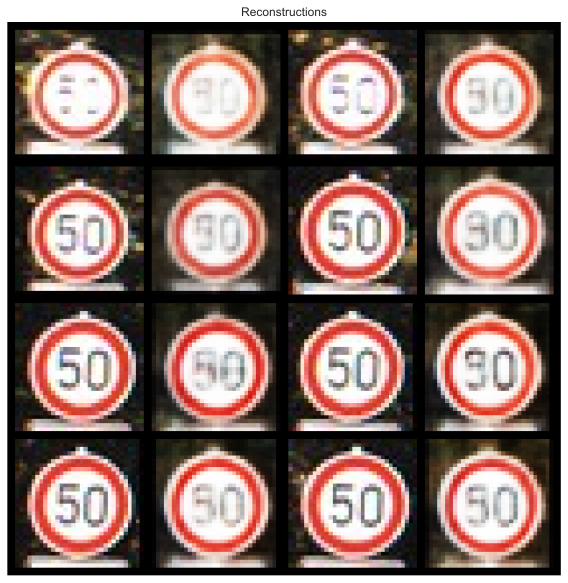

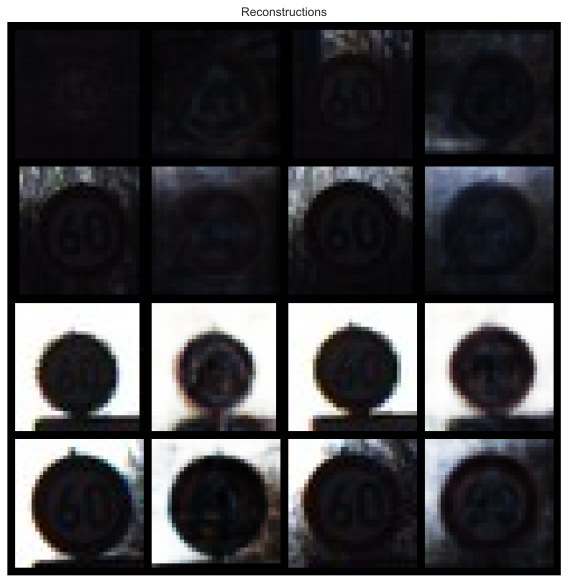

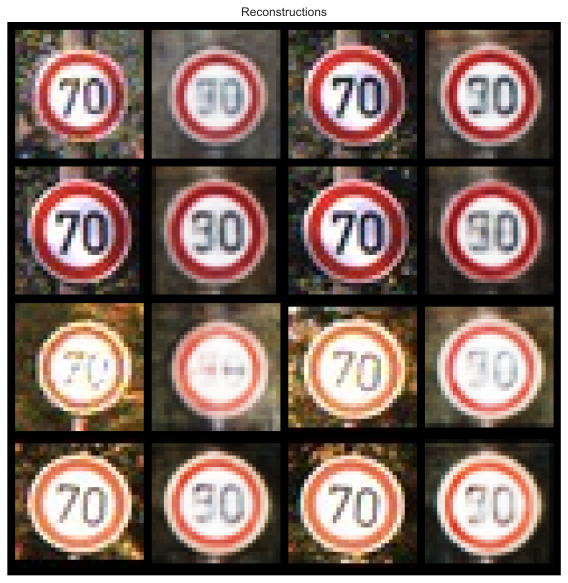

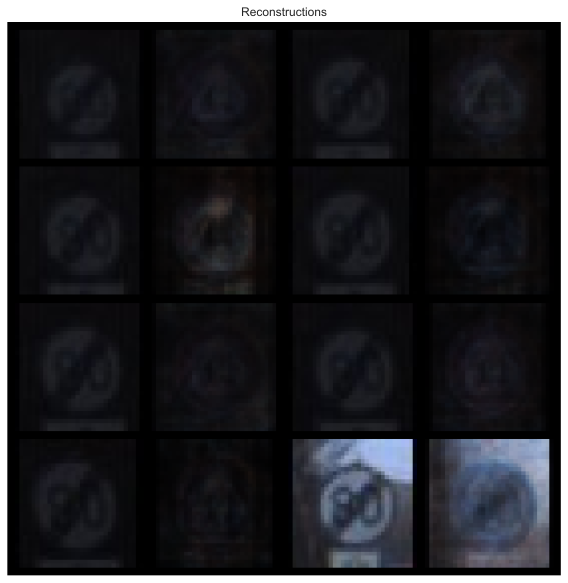

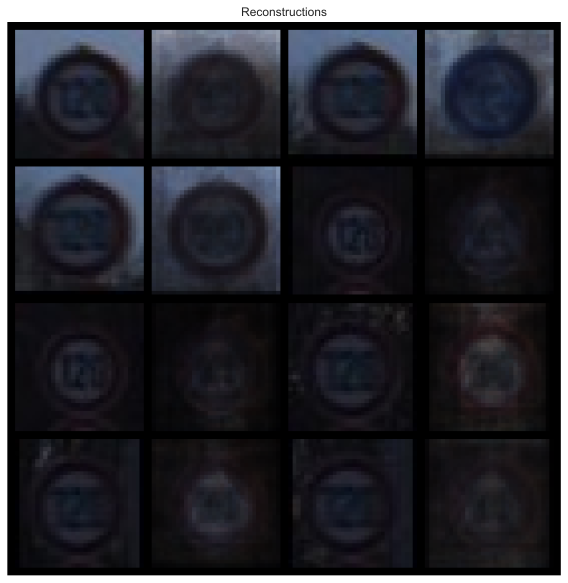

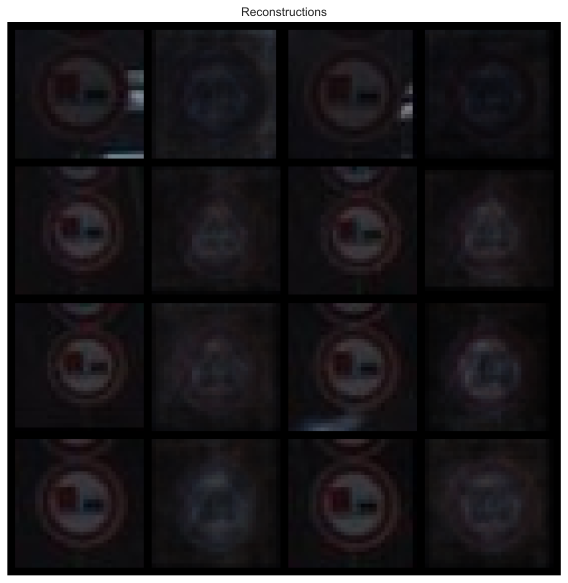

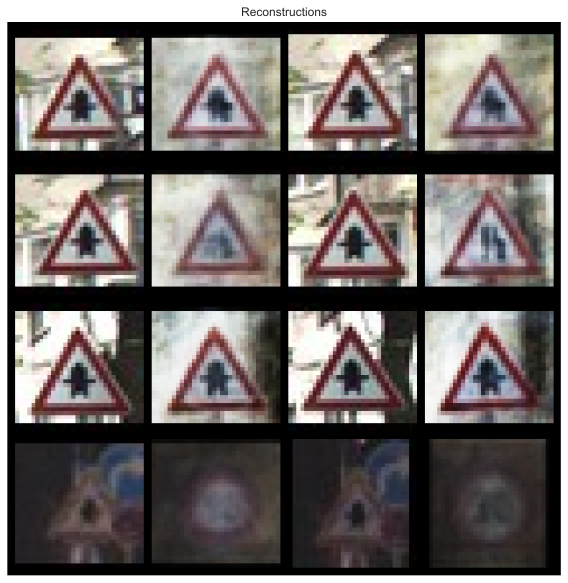

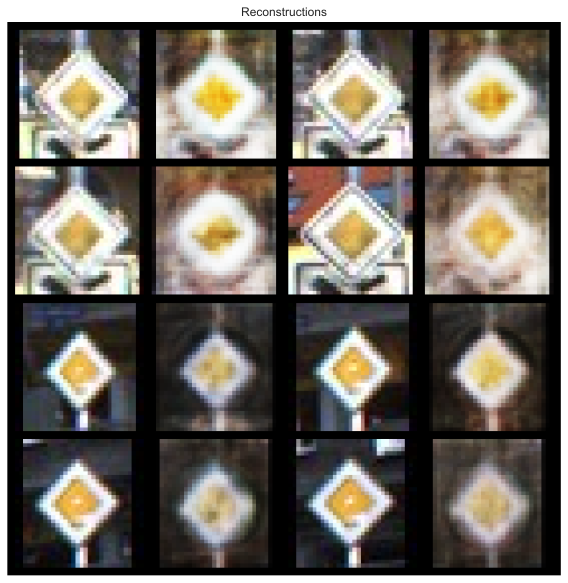

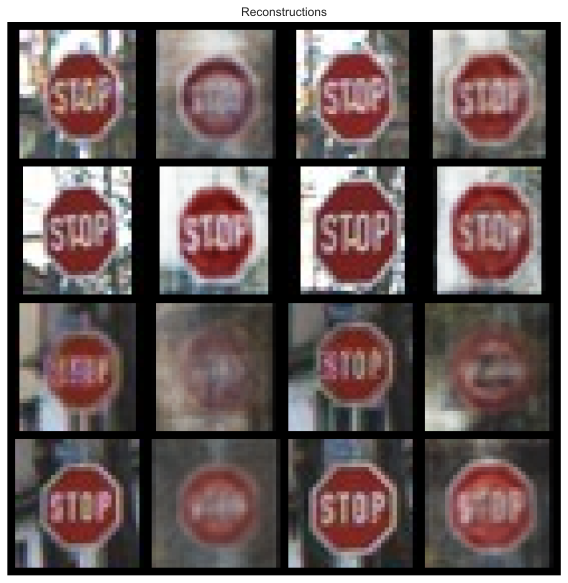

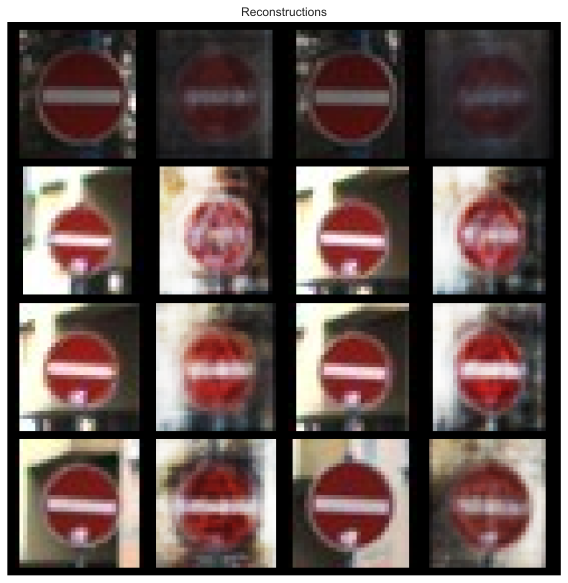

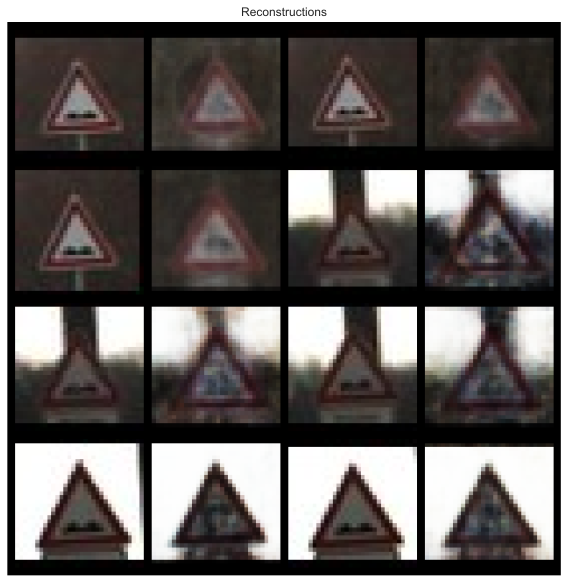

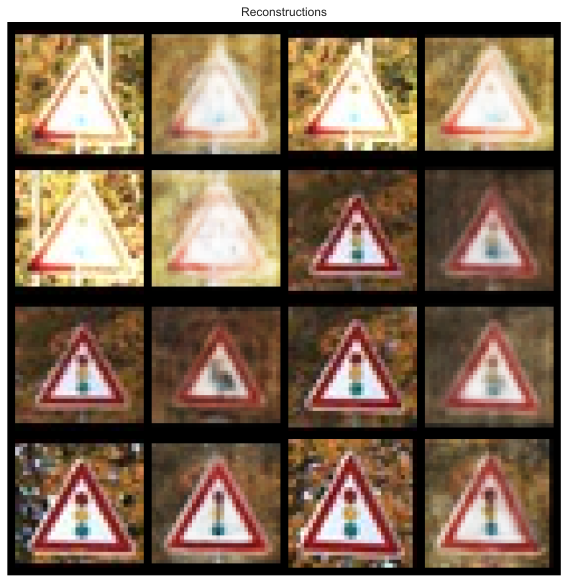

In [105]:
for i in range(13):
    # input_imgs = get_train_images(6765, 8)
    input_imgs = get_train_images(i * 500, 8)
    visualize_reconstructions(vae, input_imgs, device)

In [106]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

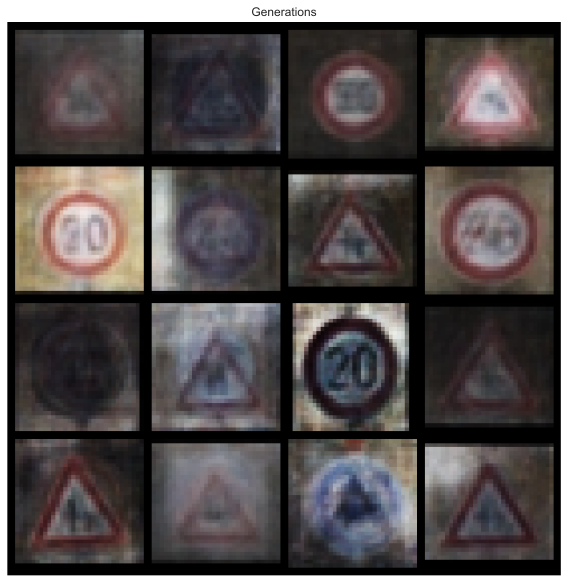

In [110]:
generate_images(vae, 16 , device)

# Testing results by Fréchet Inception Distance

## Getting sample images to reconstruct

In [115]:
for i in range(13):
    input_imgs = get_train_images(i * 500, 8)

vae.eval()
with torch.no_grad():
    reconst_imgs, means, log_var = vae(input_imgs.to(device))
reconst_imgs = reconst_imgs.cpu()

# print(reconst_imgs)
# print(input_imgs)
# print('-------')

tensor([[[[0.6667, 0.6902, 0.6863,  ..., 0.2706, 0.2627, 0.2431],
          [0.6745, 0.6824, 0.6863,  ..., 0.3255, 0.2588, 0.1725],
          [0.7098, 0.6824, 0.6510,  ..., 0.2431, 0.1843, 0.1882],
          ...,
          [0.5608, 0.5412, 0.7765,  ..., 0.9686, 0.9725, 1.0000],
          [0.5490, 0.5569, 0.7098,  ..., 0.9490, 0.9490, 0.9725],
          [0.0392, 0.0196, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.6863, 0.6824, 0.6314,  ..., 0.2039, 0.2431, 0.2549],
          [0.6863, 0.6745, 0.6314,  ..., 0.2667, 0.2471, 0.1961],
          [0.7020, 0.6588, 0.6000,  ..., 0.2078, 0.1882, 0.2157],
          ...,
          [0.5608, 0.5412, 0.7804,  ..., 0.9255, 0.9176, 0.9490],
          [0.5137, 0.5412, 0.7333,  ..., 0.9490, 0.9451, 0.9686],
          [0.0000, 0.0000, 0.0118,  ..., 0.0118, 0.0196, 0.0118]],

         [[0.6000, 0.6235, 0.6196,  ..., 0.1765, 0.2196, 0.2196],
          [0.6039, 0.6157, 0.6196,  ..., 0.2549, 0.2196, 0.1569],
          [0.6196, 0.5961, 0.5765,  ..., 0

In [116]:
torch.save(input_imgs, 'val-images.pt')
torch.save(reconst_imgs, 'reconstruct-val-images.pt')

In [ ]:
# python -m pytorch_fid val-images.pt reconstruct-val-images.pt